In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torch.autograd import Variable
from torch.backends import cudnn


import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np


# Augmenting library 

import torchvision
import torchvision.transforms.functional as TF
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"
print(torch.cuda.device_count())


# logging
import datetime
from tensorboardX import SummaryWriter
from tqdm import tqdm
import time 

/home/sklab2/anaconda3/envs/vessel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2


In [2]:
import joint_transforms
from config import cod_training_root
from config import backbone_path
from datasets import ImageFolder
from misc import AvgMeter, check_mkdir
from PFNet import PFNet

import loss

# Config

In [3]:
ckpt_path = './ckpt'
exp_name = 'PFNet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = {
    'epoch_num': 500,
    'train_batch_size': 32,
    'last_epoch': 0,
    'lr': 1e-3, 
    'lr_decay': 0.9,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'snapshot': '',
    'scale': 416, 
    'save_point': [],
    'poly_train': False,
    'optimizer': 'Adam',
    'amp' : False
}

In [4]:
# loss function
structure_loss = loss.structure_loss().to(device)
bce_loss = nn.BCEWithLogitsLoss().to(device)
iou_loss = loss.IOU().to(device)

In [5]:
def bce_iou_loss(pred, target):
    bce_out = bce_loss(pred, target)
    iou_out = iou_loss(pred, target)
    loss = bce_out + iou_out
    return loss

# Net

In [6]:
net = PFNet(backbone_path)

From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!


In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

if args['optimizer'] == 'SGD':
    print('SGD opt')
    optimizer = torch.optim.SGD([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
        'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
        'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
    ], momentum=args['momentum'])

else:
    print('Adam opt')
    optimizer = torch.optim.Adam([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
            'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
            'lr': 1 * args['lr'], 'weight_decay': args['weight_decay']}
    ])

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, \
                                threshold=0.05, threshold_mode='rel', cooldown=5, min_lr = 1e-4)

Adam opt


## making data index list

In [8]:
mask_files = os.walk("/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/masked")
mask_idx = []
for (root, dirs, files) in mask_files:
    if len(files) > 0 :
        mask_idx.append(files)

mask_idxs = [element for array in mask_idx for element in array]
len(mask_idxs)

1112

In [9]:
# 1~ 11 / 12, 13, 14  , 40, 41, 43, 44, 46, 49,     50, 53, 54, 55 

train_indexs = []
test_indexs = []

for idx, data in enumerate(mask_idxs):
    
    tmp = mask_idxs[idx].split('_')
    if len(tmp) < 3:
        if int(tmp[0]) < 45:
            train_indexs.append([ tmp[0], tmp[1].split('.')[0]])
        else:
            test_indexs.append([tmp[0], tmp[1].split('.')[0]])

In [10]:
len(train_indexs) , len(test_indexs)

(941, 171)

# Dataloader

In [11]:
import albumentations.augmentations.functional as AF

PATH = '/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/'
class VesselDataset(Dataset):
    def __init__(self, index, transforms):
        self.index = index
        self.transforms = transforms
        
    def __len__(self):
        return len(self.index)
        
    def __getitem__(self, idx):
        s_1 = self.index[idx][0]
        s_2 = self.index[idx][1]

        # '1_L_0.jpg', 
        pil_image = Image.open(PATH+'origin/' + s_1+'_L_'+s_2+'.jpg' )
        #'10_L_112_L.png', 
        pil_mask = Image.open(PATH+'masked/' +  s_1+'_L_'+s_2+'_L.png' )
        
        arr_image = np.array(pil_image, dtype=np.uint8) #RGB
        arr_mask = np.array(pil_mask, dtype=np.uint8)   # HWC
        mask_o = arr_mask          # CHW

        lower_red = np.array([-10, 100, 100]) 
        upper_red = np.array([10, 255, 255]) 

        mask_hsv = cv2.cvtColor(arr_mask, cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(mask_hsv, lower_red, upper_red)


        # # lower mask (0-10)
        # lower_red = np.array([0,50,50])
        # upper_red = np.array([10,255,255])
        # mask0 = cv2.inRange(mask_hsv, lower_red, upper_red)
        # # upper mask (170-180)
        # lower_red = np.array([170,50,50])
        # upper_red = np.array([180,255,255])
        # mask1 = cv2.inRange(mask_hsv, lower_red, upper_red)

        # mask = mask0 + mask1
        # aft_mask = np.array(mask, dtype=np.uint8)
        aft_mask = mask / 255
        masks = [aft_mask, mask_o]  # target, original

        # for num in range(3): #### 3번 이터레이션이 왜들어갔지?
        transformed = self.transforms(image=arr_image, masks=masks)
        aug_images, aug_masks = transformed['image'], transformed['masks']
        labels = aug_masks[0]
        # urls.append(s_1+'_'+s_2)
        assert sum(labels==0).sum() + sum(labels==1).sum() == 416*416   # mask가 0 또는 1이 아닐경우 스탑
                    
        return aug_images, aug_masks, s_1+'_'+s_2

In [12]:
import albumentations.pytorch as AP

transforms = A.Compose([      
    A.Resize(416, 416, interpolation=cv2.INTER_NEAREST),
    A.RandomRotate90(p=0.3),
    A.HorizontalFlip(p=0.3),
    # A.Equalize(p=1.0),
    # A.CLAHE(always_apply=True), # 위에 추가하고 
    #transforms.RandomCrop((420, 420)) , 
    #transforms.RandomVerticalFlip(p=1), 
    # A.Normalize(mean=(126.8661, 126.8530, 127.0134), std = (32.9434, 33.0122, 32.9186)),
    AP.ToTensorV2(always_apply=True)
    #!!!
])

# tensor([127.5388, 127.5482, 127.6733])
# tensor([57.4250, 57.6999, 57.5387])
train_dataset = VesselDataset(index=train_indexs, transforms=transforms)
test_dataset = VesselDataset(index=test_indexs, transforms=transforms)
 
#train_dataset, _, test_dataset = torch.utils.data.random_split(dataset, [train, 0, test])

train_loader = DataLoader(dataset=train_dataset, batch_size=args['train_batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [13]:
data, masks, urls= next(iter(train_loader))
print(data.shape, masks[0].shape, masks[1].shape)


torch.Size([32, 3, 416, 416]) torch.Size([32, 416, 416]) torch.Size([32, 416, 416, 3])


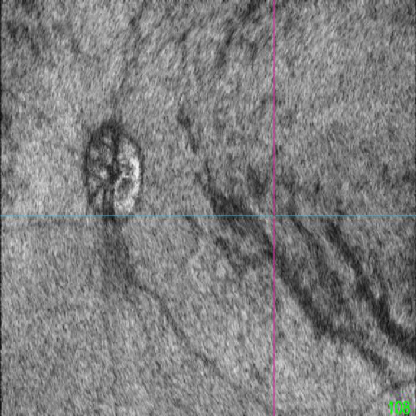

In [14]:
TF.to_pil_image(data[3])

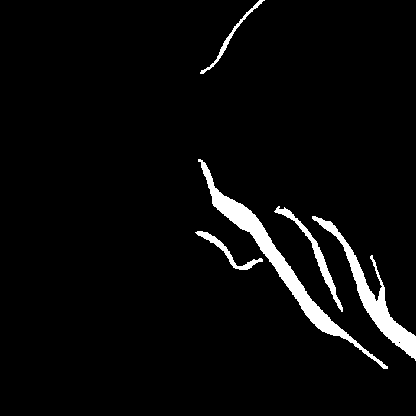

In [15]:
TF.to_pil_image(masks[0][3])

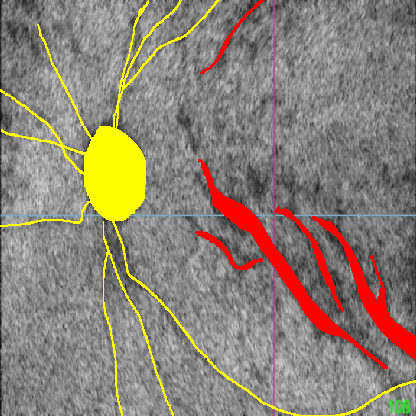

In [16]:
TF.to_pil_image(masks[1][3].permute(2, 0, 1))

In [17]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
def calc_metric(labels, preds):
    accuracy = np.mean(np.equal(labels,preds))
    right = np.sum(labels *preds == 1)
    precision = right / np.sum(preds)
    recall = right / np.sum(labels)
    f1 = 2 * precision*recall/(precision+recall)

    
    y_pred = preds
    y_true = labels
    """ Ground truth """
    #y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    #y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)
    print('jaccard, f1, recall, precision, acc')
    print(score_jaccard, score_f1, score_recall, score_precision, score_acc)
    return score_jaccard, score_f1, score_recall, score_precision, score_acc

# Train

Using 2 GPUs.
flip+rotate_b32_e500_js_220921_00:30
../model/vessel_PFNet_flip+rotate_b32_e500_220921_00:30.pt
Training 500 epochs.


100%|██████████| 30/30 [01:28<00:00,  2.96s/it, Epoch=1, Loss=7.704856, Mean Loss=9.654228, lr=0.002000]  


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.30it/s]


jaccard, f1, recall, precision, acc
0.04680122718283682 0.08941760091128058 0.04973549542457541 0.4423611049092192 0.9318189467520502
Model Saved


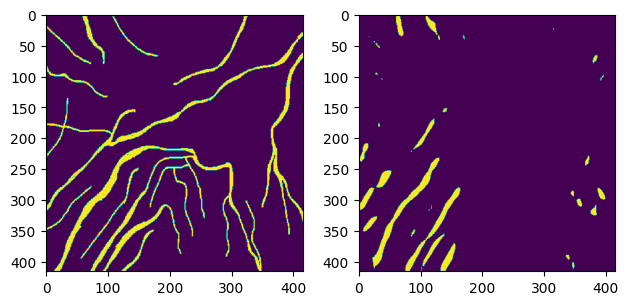

100%|██████████| 30/30 [01:17<00:00,  2.58s/it, Epoch=11, Loss=5.887552, Mean Loss=5.552993, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.22it/s]


jaccard, f1, recall, precision, acc
0.34713179348307505 0.5153642652669475 0.5410437701478585 0.4920119525095476 0.9315088351889339
Model Saved


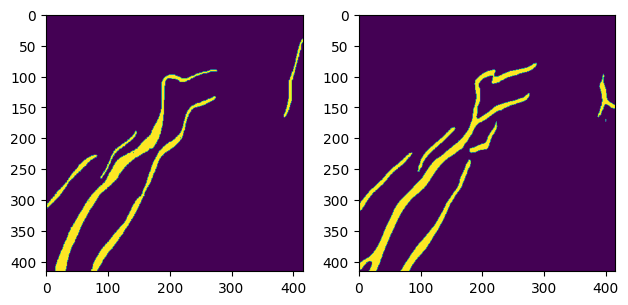

100%|██████████| 30/30 [01:17<00:00,  2.58s/it, Epoch=21, Loss=5.319993, Mean Loss=5.113126, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.26it/s]


jaccard, f1, recall, precision, acc
0.3493168619770649 0.5177684676158778 0.6355966878815887 0.43679458901276186 0.9203102156432749
Model Saved


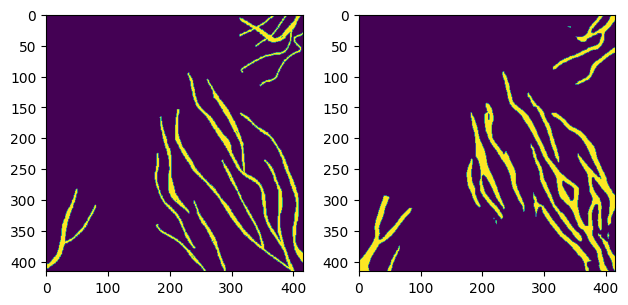

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=31, Loss=4.584531, Mean Loss=4.880574, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.31it/s]


jaccard, f1, recall, precision, acc
0.3546265610519592 0.5235783370090835 0.5736493498212957 0.4815465240506489 0.9297320381976885


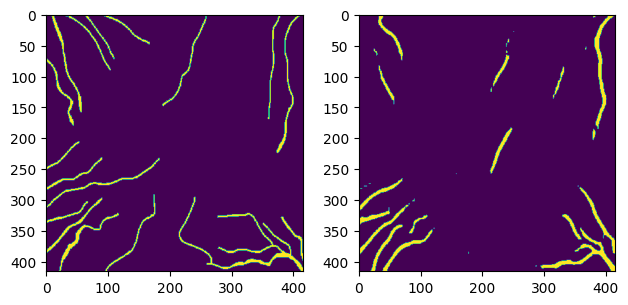

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=41, Loss=4.691442, Mean Loss=4.770247, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.30it/s]


jaccard, f1, recall, precision, acc
0.3594654682936026 0.528833540354361 0.5944296646763766 0.4762758505838166 0.9287053617772241


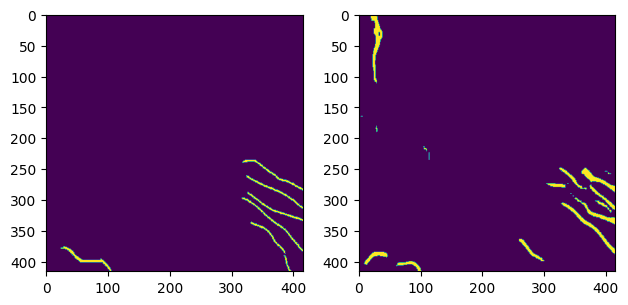

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=51, Loss=5.246575, Mean Loss=4.782145, lr=0.002000]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.31it/s]


jaccard, f1, recall, precision, acc
0.33955400836409266 0.5069657606097826 0.6333756226036569 0.42261896387116227 0.9170797094514516


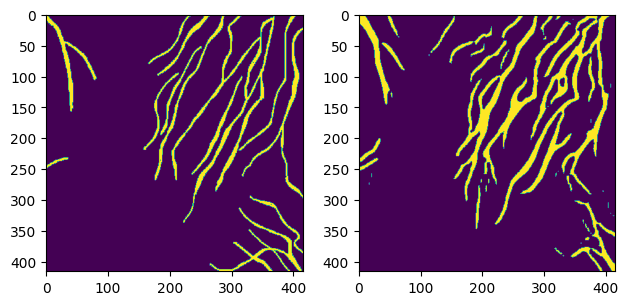

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=61, Loss=4.248446, Mean Loss=4.288013, lr=0.001000]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.42it/s]


jaccard, f1, recall, precision, acc
0.352421282399271 0.521170861455324 0.6364672410443224 0.4412400004455075 0.9212813713817952
Model Saved


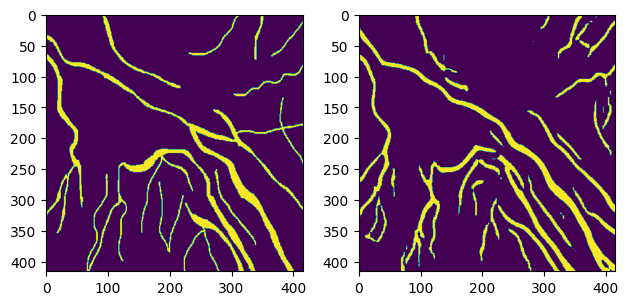

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=71, Loss=4.258473, Mean Loss=4.259603, lr=0.001000]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.41it/s]


jaccard, f1, recall, precision, acc
0.3527304160915375 0.5215088119489266 0.6264684309007212 0.44667251575656763 0.9226228902816707


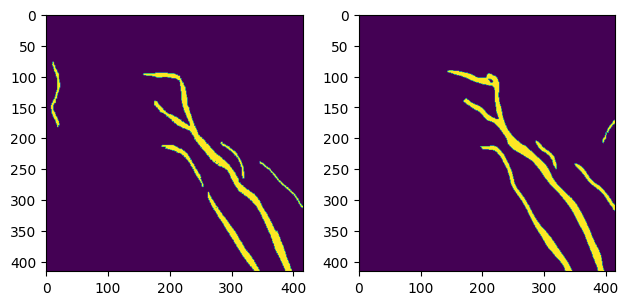

100%|██████████| 30/30 [01:16<00:00,  2.57s/it, Epoch=81, Loss=4.212301, Mean Loss=4.194669, lr=0.001000]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.41it/s]


jaccard, f1, recall, precision, acc
0.34964653708918775 0.5181305289654254 0.5373768034231716 0.5002152057212476 0.9327224503875566
Model Saved


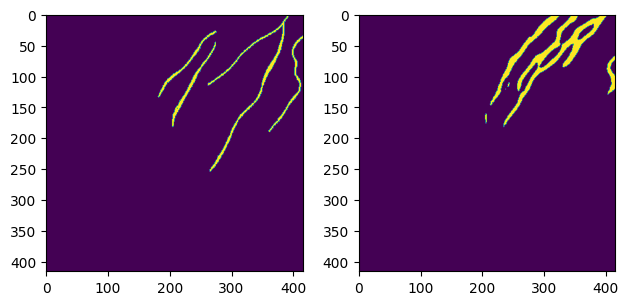

100%|██████████| 30/30 [01:17<00:00,  2.60s/it, Epoch=91, Loss=3.681988, Mean Loss=3.893111, lr=0.000500]


Testing...


100%|██████████| 171/171 [00:49<00:00,  3.46it/s]


jaccard, f1, recall, precision, acc
0.3549382000678262 0.5239179175110106 0.5843003217632768 0.4748466112489708 0.928524742151545


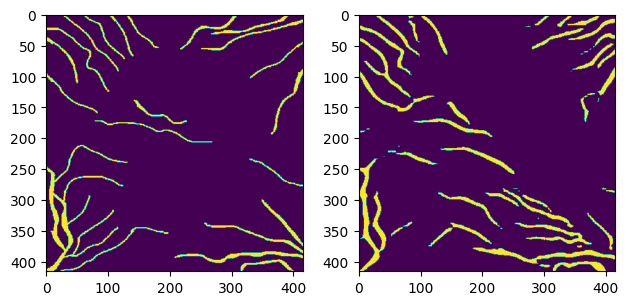

100%|██████████| 30/30 [01:18<00:00,  2.62s/it, Epoch=101, Loss=3.863714, Mean Loss=3.836576, lr=0.000500]


Testing...


100%|██████████| 171/171 [00:49<00:00,  3.45it/s]


jaccard, f1, recall, precision, acc
0.3461791754997394 0.5143136690867737 0.6072484846902633 0.44604919322897957 0.9228039154144607


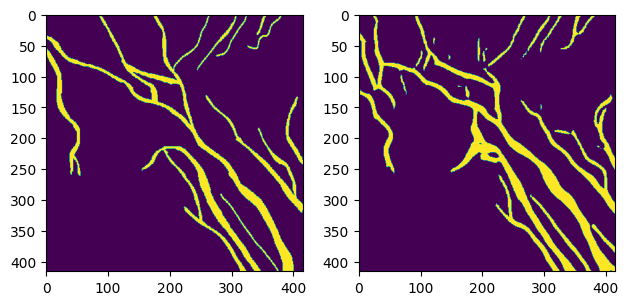

100%|██████████| 30/30 [01:17<00:00,  2.59s/it, Epoch=111, Loss=3.780540, Mean Loss=3.798448, lr=0.000500]


Testing...


100%|██████████| 171/171 [00:48<00:00,  3.51it/s]


jaccard, f1, recall, precision, acc
0.35226044161783326 0.5209949663193457 0.6018092845950748 0.45931550951311345 0.9255154062964982


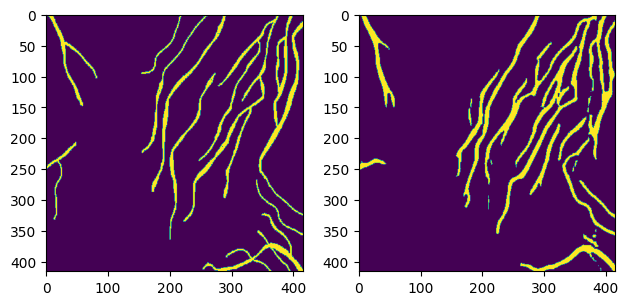

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=121, Loss=4.195550, Mean Loss=3.648691, lr=0.000250]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.33it/s]


jaccard, f1, recall, precision, acc
0.34965681399729837 0.5181418126015526 0.5763498720025785 0.4706126148506803 0.9278464301316655


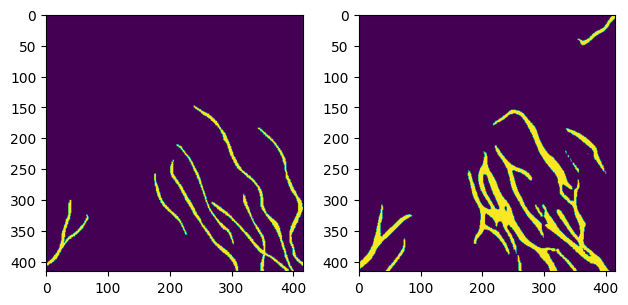

100%|██████████| 30/30 [01:17<00:00,  2.59s/it, Epoch=131, Loss=3.625104, Mean Loss=3.548068, lr=0.000250]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.34it/s]


jaccard, f1, recall, precision, acc
0.347308894117137 0.5155594171961897 0.5791176687650647 0.46457251368838215 0.9267462893395966


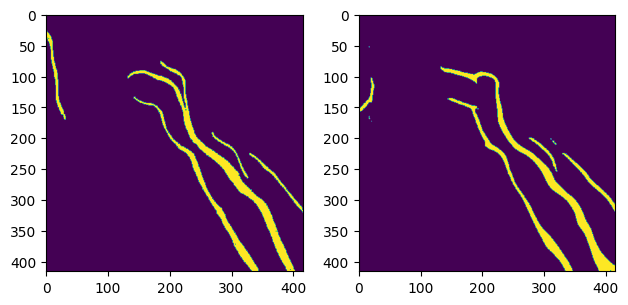

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=141, Loss=3.916828, Mean Loss=3.517096, lr=0.000250]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


jaccard, f1, recall, precision, acc
0.3468696251403627 0.5150752807335959 0.5845167049311766 0.4603813187352011 0.9259198996396935


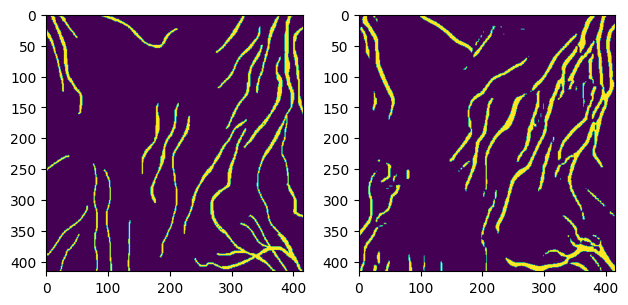

100%|██████████| 30/30 [01:18<00:00,  2.61s/it, Epoch=151, Loss=3.257558, Mean Loss=3.439469, lr=0.000125]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.37it/s]


jaccard, f1, recall, precision, acc
0.3444179180000915 0.5123673426079228 0.5781979147892121 0.45999475969695713 0.9259220623442853


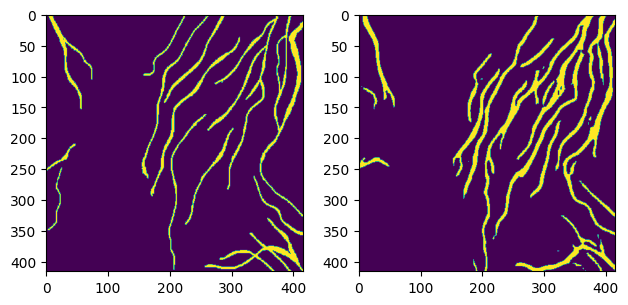

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=161, Loss=3.628731, Mean Loss=3.424387, lr=0.000125]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.40it/s]


jaccard, f1, recall, precision, acc
0.34392771582537074 0.5118247235702676 0.5745796468285307 0.4614280830036657 0.9262255844168483


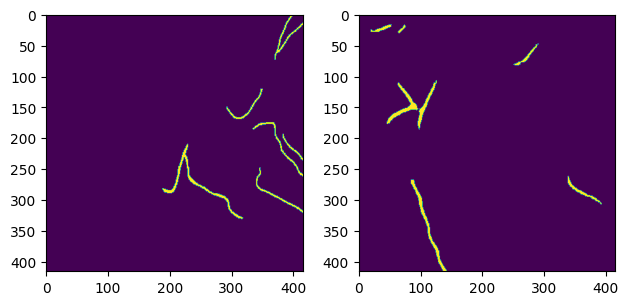

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=171, Loss=3.153164, Mean Loss=3.373473, lr=0.000125]


Testing...


100%|██████████| 171/171 [00:49<00:00,  3.47it/s]


jaccard, f1, recall, precision, acc
0.3444355092331689 0.5123868075005338 0.5734952207434645 0.4630471203382005 0.926530289218485


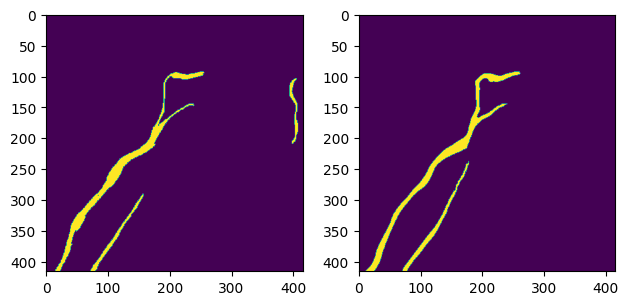

100%|██████████| 30/30 [01:17<00:00,  2.59s/it, Epoch=181, Loss=3.489041, Mean Loss=3.389655, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:47<00:00,  3.59it/s]


jaccard, f1, recall, precision, acc
0.3422684635235325 0.5099851077854545 0.5873030775108605 0.4506565426006291 0.9240347308730406


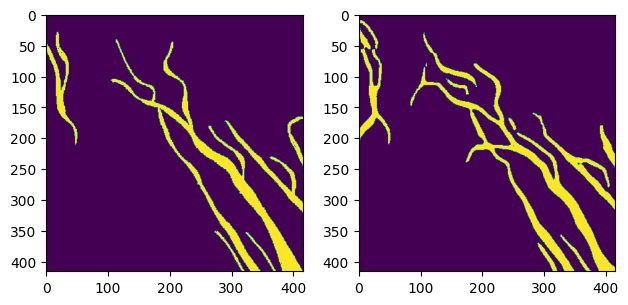

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=191, Loss=3.287258, Mean Loss=3.339640, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


jaccard, f1, recall, precision, acc
0.34373424907328726 0.5116104606403316 0.568014350571859 0.4653965318375601 0.9270059828519153


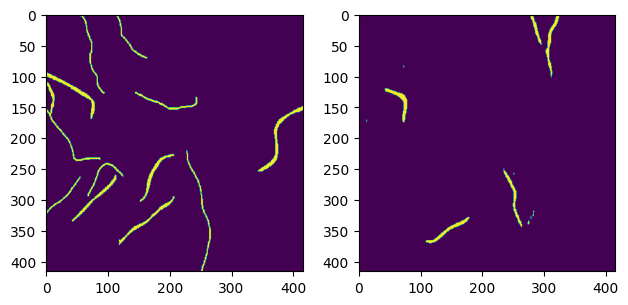

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=201, Loss=3.590965, Mean Loss=3.360565, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:49<00:00,  3.46it/s]


jaccard, f1, recall, precision, acc
0.3413508368833132 0.5089657791192894 0.5800630272457034 0.45339410551678266 0.9246645510008997


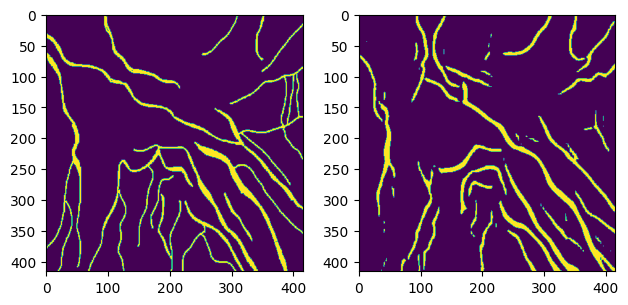

100%|██████████| 30/30 [01:17<00:00,  2.59s/it, Epoch=211, Loss=2.969449, Mean Loss=3.258187, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


jaccard, f1, recall, precision, acc
0.3432338858674824 0.5110560260260503 0.5822765617869333 0.45535924617196705 0.9250069679638568


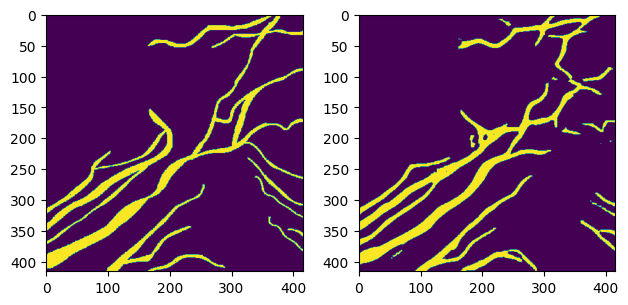

100%|██████████| 30/30 [01:17<00:00,  2.59s/it, Epoch=221, Loss=3.616188, Mean Loss=3.285536, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


jaccard, f1, recall, precision, acc
0.34295100092165787 0.5107423884956234 0.5624958267167444 0.46770989963690285 0.927463597626648


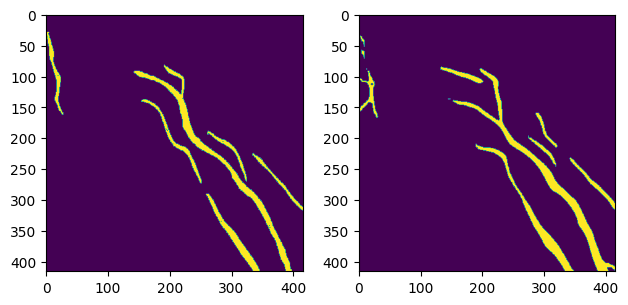

100%|██████████| 30/30 [01:17<00:00,  2.58s/it, Epoch=231, Loss=3.306318, Mean Loss=3.262382, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:51<00:00,  3.34it/s]


jaccard, f1, recall, precision, acc
0.34071986805562227 0.5082640694356995 0.569604340114176 0.45885076902544275 0.9258148732979515


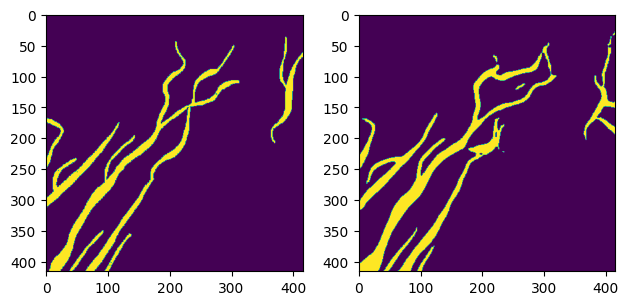

100%|██████████| 30/30 [01:17<00:00,  2.58s/it, Epoch=241, Loss=3.150317, Mean Loss=3.284819, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.39it/s]


jaccard, f1, recall, precision, acc
0.34000735995433823 0.5074708842881643 0.5682317378379858 0.4584490603379033 0.9257584064327485


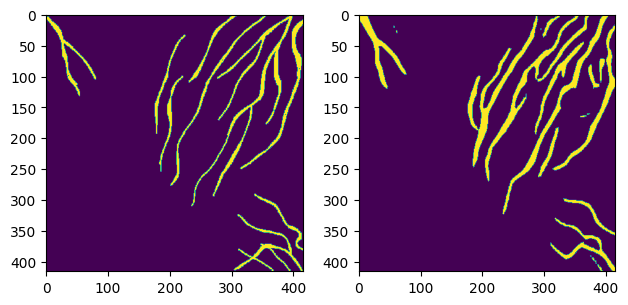

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=251, Loss=3.097059, Mean Loss=3.262890, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.38it/s]


jaccard, f1, recall, precision, acc
0.34209959859208267 0.5097976319357508 0.6032125118671859 0.44143585756789067 0.9219183554686148


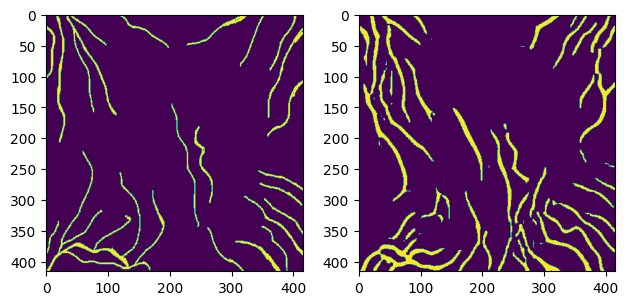

100%|██████████| 30/30 [01:21<00:00,  2.71s/it, Epoch=261, Loss=3.205969, Mean Loss=3.283865, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.40it/s]


jaccard, f1, recall, precision, acc
0.3393411125114756 0.5067284343645027 0.5793636728306584 0.450276897360491 0.9240787959790996


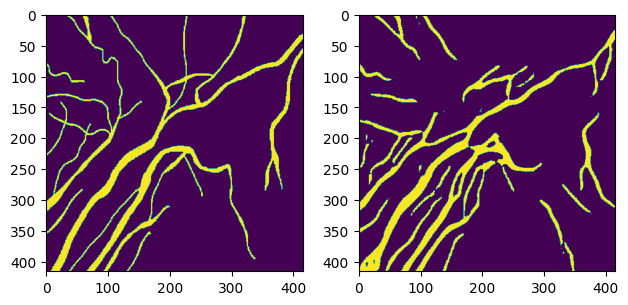

100%|██████████| 30/30 [01:17<00:00,  2.57s/it, Epoch=271, Loss=3.232783, Mean Loss=3.247651, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.39it/s]


jaccard, f1, recall, precision, acc
0.33918812454699476 0.5065578440097525 0.5673887973764922 0.4575074972957918 0.9255972511483961


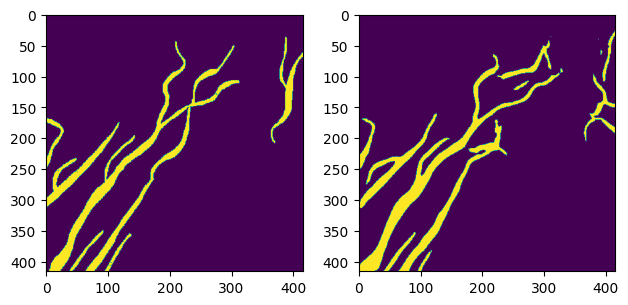

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=281, Loss=3.140686, Mean Loss=3.235814, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:49<00:00,  3.43it/s]


jaccard, f1, recall, precision, acc
0.34034780491091565 0.507849982913258 0.5655377422951777 0.46084175308701575 0.9262223741522198


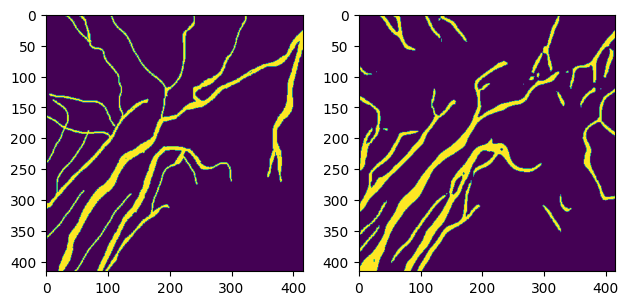

100%|██████████| 30/30 [01:18<00:00,  2.61s/it, Epoch=291, Loss=2.983488, Mean Loss=3.197173, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:50<00:00,  3.42it/s]


jaccard, f1, recall, precision, acc
0.3393253211071854 0.5067108278467758 0.5585452022429547 0.46368016337758144 0.9268017424370221


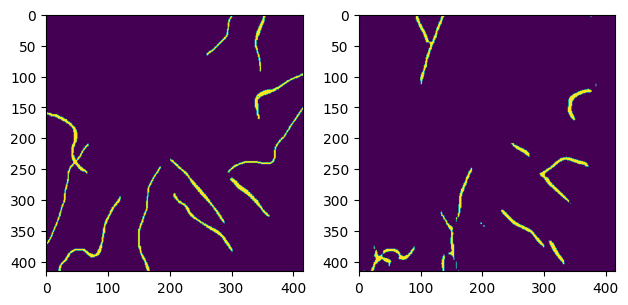

100%|██████████| 30/30 [01:18<00:00,  2.61s/it, Epoch=301, Loss=2.929929, Mean Loss=3.197228, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:48<00:00,  3.53it/s]


jaccard, f1, recall, precision, acc
0.34304585492554174 0.5108475688561804 0.5744927923319026 0.45989776352177697 0.9259477106690543


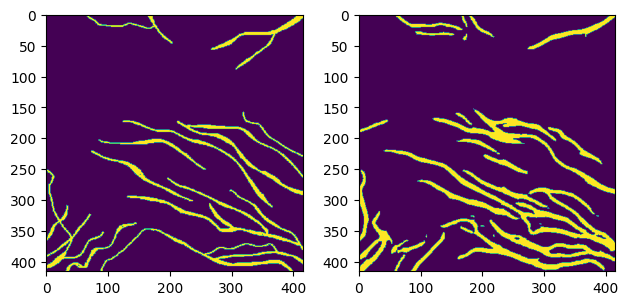

100%|██████████| 30/30 [01:19<00:00,  2.64s/it, Epoch=311, Loss=3.142591, Mean Loss=3.187775, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:47<00:00,  3.58it/s]


jaccard, f1, recall, precision, acc
0.34089960685469406 0.508464026854824 0.5725473520172585 0.45728197306079765 0.9254912110388768


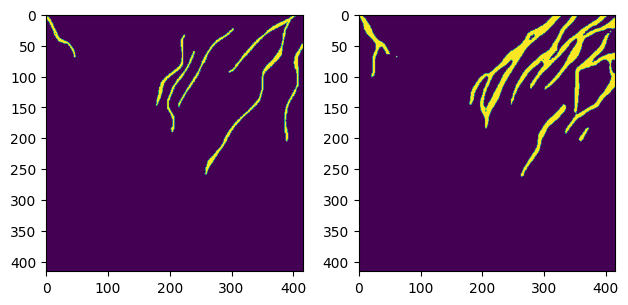

100%|██████████| 30/30 [01:18<00:00,  2.62s/it, Epoch=321, Loss=2.930214, Mean Loss=3.199849, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:47<00:00,  3.64it/s]


jaccard, f1, recall, precision, acc
0.3374103856128848 0.5045727014573201 0.5719052312011474 0.4514247829448486 0.924407053985432


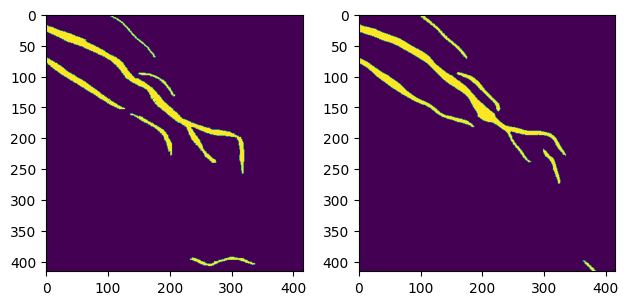

100%|██████████| 30/30 [01:09<00:00,  2.32s/it, Epoch=331, Loss=2.919969, Mean Loss=3.205522, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:40<00:00,  4.19it/s]


jaccard, f1, recall, precision, acc
0.3376389942980208 0.5048282768927655 0.5572609606107327 0.4614138479899534 0.9264179637487456


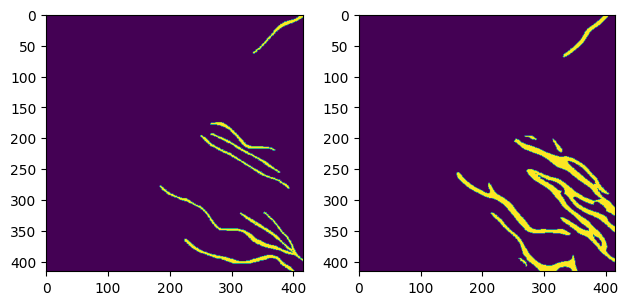

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=341, Loss=2.993109, Mean Loss=3.173345, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.11it/s]


jaccard, f1, recall, precision, acc
0.3401563490159072 0.5076368130713825 0.5707761227449837 0.4570751193452235 0.9254754638460674


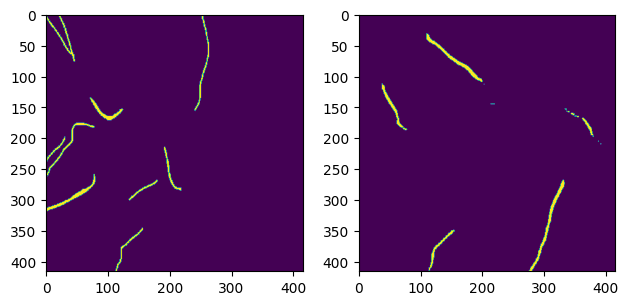

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=351, Loss=2.894518, Mean Loss=3.152864, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.19it/s]


jaccard, f1, recall, precision, acc
0.3393245609015484 0.5067099802502488 0.5567097106841574 0.4649513381332007 0.9270420391925326


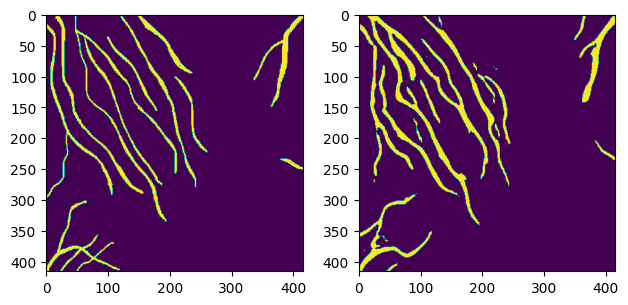

100%|██████████| 30/30 [01:14<00:00,  2.48s/it, Epoch=361, Loss=3.593839, Mean Loss=3.179551, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.13it/s]


jaccard, f1, recall, precision, acc
0.33845873839155066 0.5057440004437976 0.5629722713254147 0.4590770714676396 0.9259356468325028


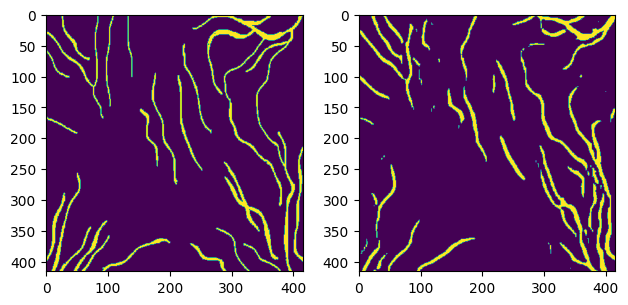

100%|██████████| 30/30 [01:14<00:00,  2.48s/it, Epoch=371, Loss=3.109245, Mean Loss=3.182857, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.14it/s]


jaccard, f1, recall, precision, acc
0.33648414347724503 0.5035363047432578 0.5495208694285727 0.4646535398675264 0.9270640041610436


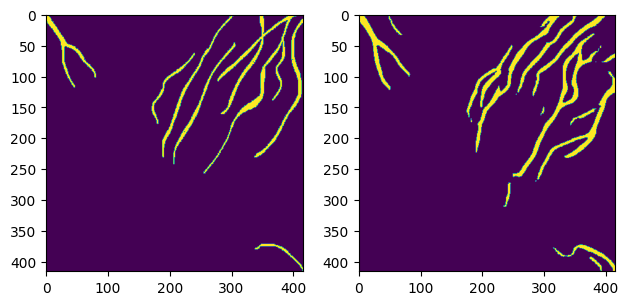

100%|██████████| 30/30 [01:14<00:00,  2.50s/it, Epoch=381, Loss=3.207210, Mean Loss=3.169321, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.07it/s]


jaccard, f1, recall, precision, acc
0.3400087500758124 0.5074724326338557 0.5797934268717772 0.45119256871984587 0.9242482979514862


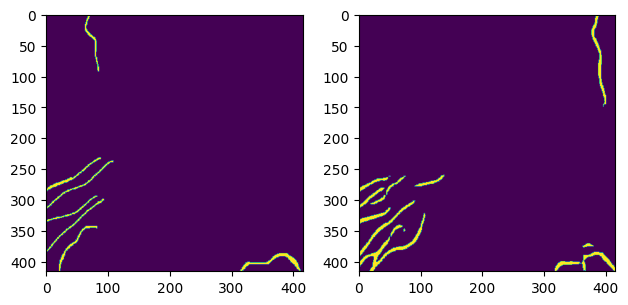

100%|██████████| 30/30 [01:16<00:00,  2.55s/it, Epoch=391, Loss=3.463887, Mean Loss=3.179316, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.09it/s]


jaccard, f1, recall, precision, acc
0.33739561646969213 0.5045561871367747 0.5568492803376983 0.46124151249713063 0.9263922478394581


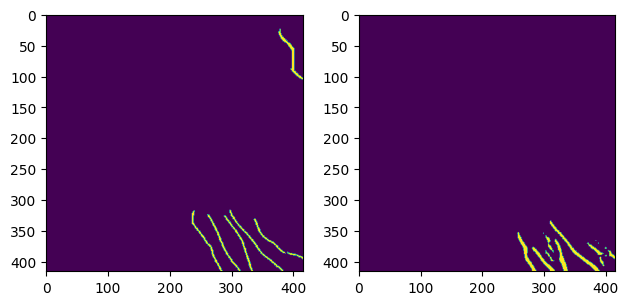

100%|██████████| 30/30 [01:16<00:00,  2.56s/it, Epoch=401, Loss=2.625478, Mean Loss=3.122891, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.10it/s]


jaccard, f1, recall, precision, acc
0.33574107983143214 0.5027038322034716 0.5700883154595482 0.44956519157107083 0.9240817696979134


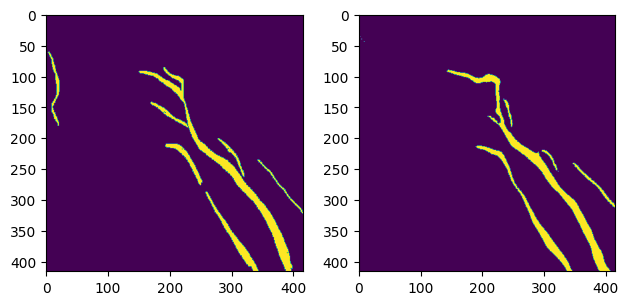

100%|██████████| 30/30 [01:19<00:00,  2.65s/it, Epoch=411, Loss=2.881520, Mean Loss=3.128530, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.09it/s]


jaccard, f1, recall, precision, acc
0.33867347971203915 0.5059836993034192 0.5747347800045888 0.45192357418096163 0.9244606485085989


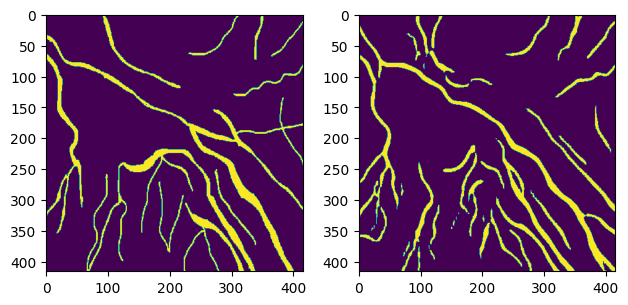

100%|██████████| 30/30 [01:15<00:00,  2.53s/it, Epoch=421, Loss=3.236627, Mean Loss=3.108986, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:54<00:00,  3.17it/s]


jaccard, f1, recall, precision, acc
0.3360010949352387 0.5029952388647196 0.5657194840742491 0.45279186307842095 0.9247513295226478


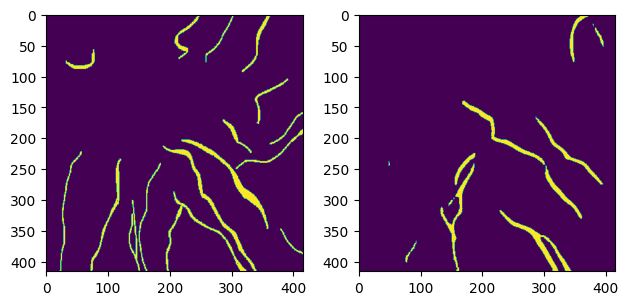

100%|██████████| 30/30 [01:16<00:00,  2.54s/it, Epoch=431, Loss=2.698660, Mean Loss=3.110562, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:52<00:00,  3.24it/s]


jaccard, f1, recall, precision, acc
0.33874173648470557 0.5060598728686538 0.5581099256615878 0.46289014029144243 0.926668060259438


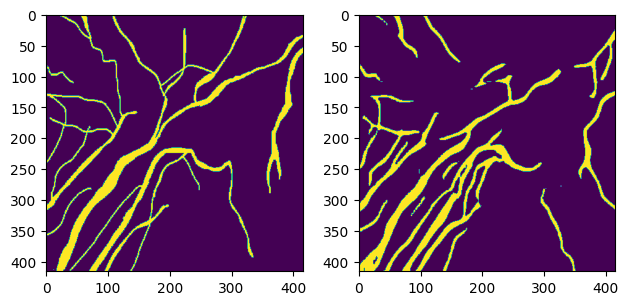

100%|██████████| 30/30 [01:15<00:00,  2.53s/it, Epoch=441, Loss=3.245095, Mean Loss=3.122823, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.21it/s]


jaccard, f1, recall, precision, acc
0.33472172684162077 0.5015603179453438 0.5484178675263086 0.4620796224713474 0.9266327811407834


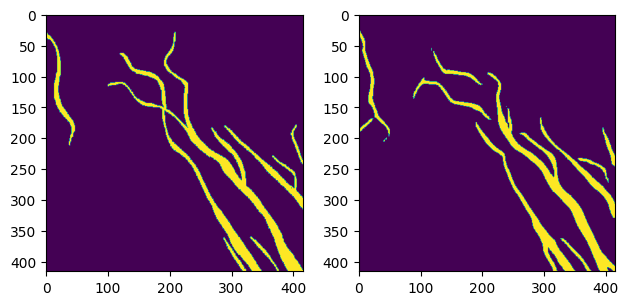

100%|██████████| 30/30 [01:15<00:00,  2.50s/it, Epoch=451, Loss=2.795232, Mean Loss=3.134983, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:53<00:00,  3.19it/s]


jaccard, f1, recall, precision, acc
0.33621697118676414 0.5032370916351291 0.5810701377672972 0.44379212805663865 0.9227842145273193


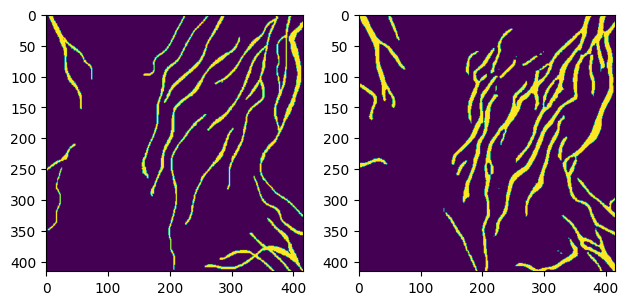

100%|██████████| 30/30 [01:13<00:00,  2.46s/it, Epoch=461, Loss=3.012185, Mean Loss=3.100913, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.07it/s]


jaccard, f1, recall, precision, acc
0.33620807453601464 0.5032271259889813 0.5657470967754892 0.4531501016784484 0.9248174271817364


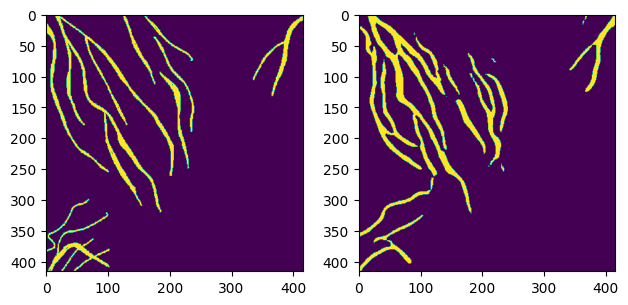

100%|██████████| 30/30 [01:14<00:00,  2.47s/it, Epoch=471, Loss=3.042619, Mean Loss=3.104276, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.09it/s]


jaccard, f1, recall, precision, acc
0.33542265346449335 0.5023468077230901 0.5628010725777259 0.45362037869949867 0.9249450943371743


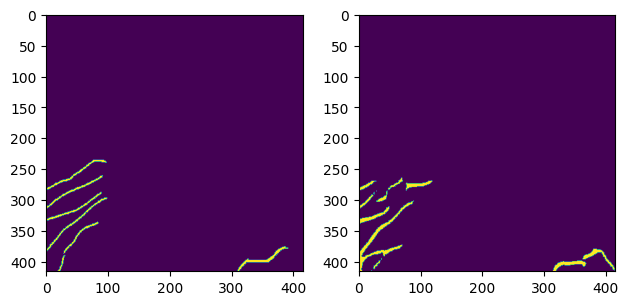

100%|██████████| 30/30 [01:15<00:00,  2.52s/it, Epoch=481, Loss=3.035723, Mean Loss=3.123863, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:55<00:00,  3.10it/s]


jaccard, f1, recall, precision, acc
0.33574770444107704 0.5027112580089598 0.5644161645757158 0.4531685215715835 0.9248393583579881


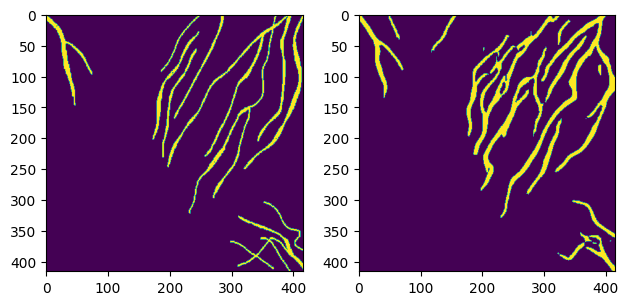

100%|██████████| 30/30 [01:18<00:00,  2.62s/it, Epoch=491, Loss=3.138563, Mean Loss=3.094693, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:56<00:00,  3.02it/s]


jaccard, f1, recall, precision, acc
0.3339868042724692 0.5007347946813 0.5531346189472331 0.45740379090567906 0.9257570209501194


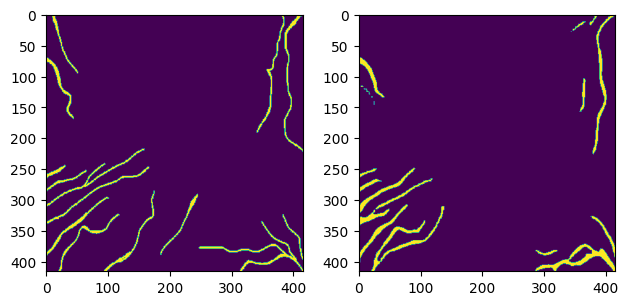

100%|██████████| 30/30 [01:18<00:00,  2.61s/it, Epoch=500, Loss=2.954862, Mean Loss=3.096376, lr=0.000100]


Testing...


100%|██████████| 171/171 [00:56<00:00,  3.00it/s]


jaccard, f1, recall, precision, acc
0.3392051014650105 0.5065767761695954 0.5721959176378388 0.45445957908336193 0.9249725674439427


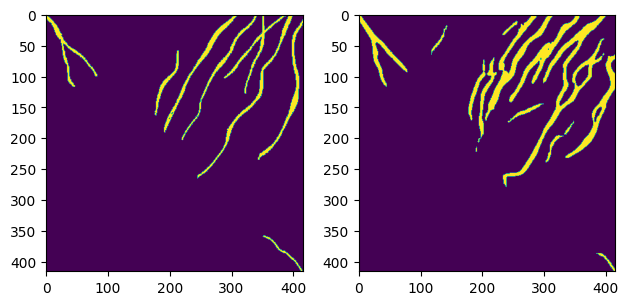

In [18]:
from tensorboardX import SummaryWriter
import datetime 

exp = 'flip+rotate'

num_epochs = args['epoch_num']
batch_size = args['train_batch_size']
scaler = torch.cuda.amp.GradScaler()
now = datetime.datetime.now()
log_name = f'{exp}_b{batch_size}_e{num_epochs}_js_'+now.strftime("%y%m%d_%H:%M")
writer = SummaryWriter(log_dir='./ckpt/PFNet/log/'+ log_name)
save_path = f'../model/vessel_PFNet_{exp}_b{batch_size}_e{num_epochs}_'+ now.strftime("%y%m%d_%H:%M") + '.pt'

if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    net = nn.DataParallel(net)

# net.float()
net = net.to(device)
train_loss_list = []
test_acc_list = []
test_recall_list = []

print(log_name)
print(save_path)
print(f'Training {num_epochs} epochs.')
if args['amp'] == True:
    print("Using mixed precision.")


curr_iter = 1

for epoch in range(num_epochs):
    
    net.train()

    loss_1_running, loss_2_running, loss_3_running, loss_4_running, loss_running = 0, 0, 0, 0, 0
    tqdm_dataset = tqdm(train_loader)
    for batch_idx, batch in enumerate(tqdm_dataset):
        if args['poly_train']:
            base_lr = args['lr'] * (1 - float(curr_iter) / float(num_epochs)) ** args['lr_decay']
            optimizer.param_groups[0]['lr'] = 2 * base_lr
            optimizer.param_groups[1]['lr'] = 1 * base_lr

        inputs, label_list, _ = batch

        labels = label_list[0]
        labels = labels.unsqueeze(1)
        inputs, labels = inputs.float().to(device), labels.float().to(device)
        optimizer.zero_grad()

        # mixed precision
        if args['amp'] == True:
            with torch.cuda.amp.autocast():

                predict_1, predict_2, predict_3, predict_4 = net(inputs)
                
                loss_1 = bce_iou_loss(predict_1, labels)
                loss_2 = structure_loss(predict_2, labels)
                loss_3 = structure_loss(predict_3, labels)
                loss_4 = structure_loss(predict_4, labels)
                loss = 1 * loss_1 + 1 * loss_2 + 2 * loss_3 + 4 * loss_4

            scaler.scale(loss).backward()
            # nn.utils.clip_grad_norm_(net.parameters(), max_norm=5)
            scaler.step(optimizer)
            scaler.update()

        else:
            predict_1, predict_2, predict_3, predict_4 = net(inputs)

            loss_1 = bce_iou_loss(predict_1, labels)
            loss_2 = structure_loss(predict_2, labels)
            loss_3 = structure_loss(predict_3, labels)
            loss_4 = structure_loss(predict_4, labels)
            loss = 1 * loss_1 + 1 * loss_2 + 2 * loss_3 + 4 * loss_4
            
            loss.backward()
            # nn.utils.clip_grad_norm_(net.parameters(), max_norm=5)
            optimizer.step()
        
        loss_1_running += loss_1.item()
        loss_2_running += loss_2.item()
        loss_3_running += loss_3.item()
        loss_4_running += loss_4.item()
        loss_running += loss.item()
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(loss_running/(batch_idx+1)),
            'lr' : '{:06f}'.format(optimizer.param_groups[0]["lr"])
        })

        curr_iter += 1

    epoch_loss = loss_running / len(train_loader)
    epoch_loss_1 = loss_1_running / len(train_loader)
    epoch_loss_2 = loss_2_running / len(train_loader)
    epoch_loss_3 = loss_3_running / len(train_loader)
    epoch_loss_4 = loss_4_running / len(train_loader)

    scheduler.step(epoch_loss)

    writer.add_scalar('loss/Train', epoch_loss, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    train_loss_list.append(epoch_loss)

## EVAL
    if epoch % 10 == 0 or epoch == args['epoch_num']-1 :
        print("Testing...")

        inputs=[]
        preds=[]
        labels=[]
        # label_os = []
        urls_list = []
        net.eval()
        tqdm_loader = tqdm(test_loader)
        with torch.no_grad():
            for idx, dd in enumerate(tqdm_loader):
                data, target, urls = dd 
                
                data = data.float().to(device)
                label = target[0].float()
                # label_o = target[1].float()
                _, _, _, pred = net(data)    

                inputs.append(data.cpu().detach().numpy())
                labels.append(label.numpy())
                # label_os.append(label_o)
                preds.append(pred.cpu().detach().numpy())
                urls_list.append(urls)

            inputs = np.array(inputs).squeeze(1)
            preds = np.array(preds).squeeze(1)
            labels = np.array(labels)
            preds = np.where(preds > 0.5 , 1 , 0)
            labels = np.where(labels > 0.5 , 1 , 0)
            
            score_jaccard, score_f1, score_recall, score_precision, score_acc = calc_metric(labels=labels, preds=preds)
            test_acc_list.append(score_acc)
            test_recall_list.append(score_recall)
            writer.add_scalar('Accuracy/Test', score_acc, epoch)
            writer.add_scalar('F1/Test', score_f1, epoch)
            writer.add_scalar('Recall/Test', score_recall, epoch)
            writer.add_scalar('Precision/Test', score_precision, epoch)
            writer.add_scalar('Jaccard/Test', score_jaccard, epoch)

            if np.max(test_acc_list) == test_acc_list[-1] or np.max(test_recall_list) == test_recall_list[-1]:
                torch.save(net.state_dict(), save_path)
                print("Model Saved")

            randnum = np.random.randint(0, 171)
            plt.subplot(1, 2, 1)  
            plt.imshow(labels[randnum][0])
            plt.subplot(1, 2, 2)  
            plt.imshow(preds[randnum][0])
            plt.tight_layout()
            plt.show()

# evaluation

In [20]:
# save_model = torch.load('../model/vessel_PFNet_baseline_e200_JS_220918_19:44.pt')
save_model = torch.load(save_path)
net = PFNet(backbone_path)
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)
net.load_state_dict(save_model)


inputs=[]
preds=[]
labels=[]
label_os = []
urls_list = []

net.eval()
net.to(device)
tqdm_loader = tqdm(test_loader)
with torch.no_grad():
    for idx, dd in enumerate(tqdm_loader):
        data, target, urls = dd 
        
        data = data.float().to(device)
        label = target[0].float()
        label_o = target[1].float()
        _, _, _, pred = net(data)    

        inputs.append(data.cpu().detach().numpy())
        labels.append(label.numpy())
        label_os.append(label_o)
        preds.append(pred.cpu().detach().numpy())
        urls_list.append(urls)
        # if idx == 0:


inputs = np.array(inputs).squeeze(1)
preds = np.array(preds).squeeze(1)
labels = np.array(labels)

From ./backbone/resnet/resnet50-19c8e357.pth Load resnet50 Weights Succeed!


  0%|          | 0/171 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/sklab2/workspace/datashared/SS-OCT/vessel_segmentation/masked/13_L_15_L.png'

In [ ]:
preds = np.where(preds > 0.5 , 1 , 0)
labels = np.where(labels > 0.5 , 1 , 0)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

y_pred = preds
y_true = labels

print(type(y_pred) , type(y_true))

In [19]:
""" Ground truth """
#y_true = y_true.cpu().numpy()
y_true = y_true > 0.5
y_true = y_true.astype(np.uint8)
y_true = y_true.reshape(-1)

""" Prediction """
#y_pred = y_pred.cpu().numpy()
y_pred = y_pred > 0.5
y_pred = y_pred.astype(np.uint8)
y_pred = y_pred.reshape(-1)

score_jaccard = jaccard_score(y_true, y_pred)
score_f1 = f1_score(y_true, y_pred)
score_recall = recall_score(y_true, y_pred)
score_precision = precision_score(y_true, y_pred)
score_acc = accuracy_score(y_true, y_pred)

NameError: name 'y_true' is not defined

In [ ]:
print( score_jaccard, score_f1, score_recall, score_precision , score_acc)

In [ ]:
inputs[0].astype(int)

In [ ]:
plt.imshow(inputs[0].astype(int).transpose(1, 2, 0))

In [ ]:
plt.imshow(inputs[0].astype(int).transpose(1,2,0))

In [ ]:
fig, axes = plt.subplots(10, 3, figsize = (10,40))
[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, target_ax , mask_ax ) in zip(range(10), axes):
    
# inputs[:10] , preds[:10], targets[:10], urls_list[:10]) :
    
    image = inputs[idx].astype(int).transpose(1, 2, 0) # astype(int)
    img_target = preds[idx].transpose(1, 2, 0) 
    img_mask = labels[idx].transpose(1, 2, 0)  
 
    img_ax.imshow(np.clip(image, 0, 255))

    target_ax.imshow(img_target )
    mask_ax.imshow(img_mask)

    img_ax.set_title(f'  testing: {idx}')
    target_ax.set_title(f' Predicted : {idx}')
    
    mask_ax.set_title(f' target   vessel: {idx}')
plt.tight_layout()
plt.show()
 